In [7]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives

Equation:

\begin{align*}
0 &= \max_{e}\min_{h_2} b\left[\delta \eta \log e - \tau z_2 e + \xi_m \frac{(h_2)^2}{2}\right] - \ell e - \frac{\partial \psi}{\partial b}(b,z_2;\ell) \delta b\\
&+\left[\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC for $h_2$ gives:
$$
h^* = -\frac{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)\sqrt{z_2}\sigma_2}{b\xi_m}
$$

FOC for $e$ gives:
$$
e^* = \frac{b\delta \eta}{b\tau z_2 + \ell}
$$

Solve:

\begin{align*}
\frac{\color{red}{\psi_{i+1}(b,z_2;\ell)}-\color{blue}{\psi_{i}(b,z_2;\ell)}}{\epsilon} &= b\left[\delta \eta \log \color{blue}{e^*} - \tau z_2 \color{blue}{e^*} + \xi_m \frac{(\color{blue}{h_2^*})^2}{2}\right] - \ell \color{blue}{e^*} - \color{red}{\frac{\partial \psi}{\partial b}(b,z_2;\ell)} \delta b\\
&+\left[\color{red}{\frac{\partial \psi}{\partial z_2}(b,z_2;\ell)}\right]\left[-\rho(z_2-\mu_2)+\sqrt{z_2}\sigma_2 \color{blue}{h_2^*}\right] + \left[\color{red}{\frac{\partial^2 \psi}{\partial(z_2)^2}(b,z_2;\ell)}\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

In [ ]:
def false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, b_grid, ℓ, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    τ, η, ξ_m, δ, η, μ_2, ρ, σ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (z_mat, b_mat) = np.meshgrid(z_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives(v0, 0, 2, Δ_z)
        v0_db = compute_derivatives(v0, 1, 1, Δ_b)

        e = b_mat*δ*η / (b_mat*τ*z_mat + ℓ)
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / (b_mat*ξ_m)

        A = np.zeros_like(z_mat)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_b = -(δ*b_mat)
        C_zz = z_mat*σ_2**2/2
        C_bb = np.zeros_like(z_mat)
        D = b_mat*(δ*η*np.log(e) - τ*z_mat*e + ξ_m*h**2/2) - ℓ*e

        res = false_transient_one_iteration(stateSpace, A, B_z, B_b, C_zz, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_b*v0_db + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

#         print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [ ]:
# Model parameters
median = 1.75/1000
γ = .018
τ = median * γ
η = .032
ξ_m = .00256/20.
δ = .01
η = .032

μ_2 = 1.
ρ = .5
σ_2 = np.sqrt((.21)**2*2*ρ/μ_2) # Match moments, using 100 year's std

model_paras = (τ, η, ξ_m, δ, η, μ_2, ρ, σ_2)

In [4]:
# Grid setting
n_z = 20
z_min = 0.3 # 0.1%
z_max = 1.9 # 99.9%
z_grid = np.linspace(z_min, z_max, n_z)

n_b = 100
b_min = 1e-2
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

In [5]:
log_ell_grid = np.linspace(-13, -5, 200)
ℓ_step = 1e-7

In [6]:
ψs = []
es = []
ψs_next = []
es_next = []

# ψ_guess, _ = false_transient(z_grid, b_grid, 1e-5, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=2000)

for i, ℓ in enumerate(np.exp(log_ell_grid)):
    print(i)
    max_iter = 1000
    ψ, e = false_transient(z_grid, b_grid, ℓ, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψ_next, e_next = false_transient(z_grid, b_grid, ℓ+ℓ_step, model_paras=model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=max_iter)
    ψs.append(ψ)
    es.append(e)
    ψs_next.append(ψ_next)
    es_next.append(e_next)

0
Iteration 1000: LHS Error: 3.6477274980564398e-06; RHS Error 2.0428034212139267e-05
Iteration 1000: LHS Error: 3.677189139763854e-06; RHS Error 2.031229265507062e-05
1
Iteration 1000: LHS Error: 3.6751159078383076e-06; RHS Error 2.0320721088152183e-05
Iteration 1000: LHS Error: 3.702667629474233e-06; RHS Error 2.0205011494583958e-05
2
Iteration 1000: LHS Error: 3.7017417234426996e-06; RHS Error 2.0209033238375467e-05
Iteration 1000: LHS Error: 3.7274960579970068e-06; RHS Error 2.009352623557443e-05
3
Iteration 1000: LHS Error: 3.7276158276265507e-06; RHS Error 2.0092970977841408e-05
Iteration 1000: LHS Error: 3.751679928716816e-06; RHS Error 1.997783231763681e-05
4
Iteration 1000: LHS Error: 3.752749846060773e-06; RHS Error 1.997254351092262e-05
Iteration 1000: LHS Error: 3.7752256101374754e-06; RHS Error 1.985793427409328e-05
5
Iteration 1000: LHS Error: 3.7771560707010148e-06; RHS Error 1.9847769693234416e-05
Iteration 1000: LHS Error: 3.798140263684517e-06; RHS Error 1.97338461976

Iteration 1000: LHS Error: 7.0829749826660515e-06; RHS Error 1.2603022431101059e-05
Iteration 1000: LHS Error: 7.096411504457084e-06; RHS Error 1.2584621888236545e-05
50
Iteration 1000: LHS Error: 7.170788442065895e-06; RHS Error 1.2485142256873016e-05
Iteration 1000: LHS Error: 7.183699464688442e-06; RHS Error 1.246828745694238e-05
51
Iteration 1000: LHS Error: 7.258617842949983e-06; RHS Error 1.2372934794071112e-05
Iteration 1000: LHS Error: 7.271023697033585e-06; RHS Error 1.2357551790236228e-05
52
Iteration 1000: LHS Error: 7.3464628318059555e-06; RHS Error 1.2266528487974283e-05
Iteration 1000: LHS Error: 7.35838336785033e-06; RHS Error 1.2252543895839964e-05
53
Iteration 1000: LHS Error: 7.434322937316384e-06; RHS Error 1.2166032957330582e-05
Iteration 1000: LHS Error: 7.445776816290134e-06; RHS Error 1.215337342265016e-05
54
Iteration 1000: LHS Error: 7.522196844928636e-06; RHS Error 1.207153860052632e-05
Iteration 1000: LHS Error: 7.533202236356673e-06; RHS Error 1.206013172382

Iteration 1000: LHS Error: 1.1396633701754588e-05; RHS Error 1.2826765508973761e-05
Iteration 1000: LHS Error: 1.1398520146019275e-05; RHS Error 1.2828500914198507e-05
99
Iteration 1000: LHS Error: 1.1484787577328848e-05; RHS Error 1.2908333569750444e-05
Iteration 1000: LHS Error: 1.1486599762453031e-05; RHS Error 1.2910020245556933e-05
100
Iteration 1000: LHS Error: 1.1572940113502295e-05; RHS Error 1.2990818560471015e-05
Iteration 1000: LHS Error: 1.157468095880354e-05; RHS Error 1.299245612462902e-05
101
Iteration 1000: LHS Error: 1.1661096738779797e-05; RHS Error 1.3074144498478386e-05
Iteration 1000: LHS Error: 1.1662769084583302e-05; RHS Error 1.3075732860714449e-05
102
Iteration 1000: LHS Error: 1.1749255164922312e-05; RHS Error 1.3158241526610112e-05
Iteration 1000: LHS Error: 1.1750861642040311e-05; RHS Error 1.3159780712865369e-05
103
Iteration 1000: LHS Error: 1.1837415229545845e-05; RHS Error 1.3243043461337023e-05
Iteration 1000: LHS Error: 1.1838958459131632e-05; RHS Erro

Iteration 1000: LHS Error: 1.562932316459542e-05; RHS Error 1.7089202223169388e-05
Iteration 1000: LHS Error: 1.5629597317295962e-05; RHS Error 1.7089480750699854e-05
147
Iteration 1000: LHS Error: 1.571752028955986e-05; RHS Error 1.717878117471624e-05
Iteration 1000: LHS Error: 1.5717783641261418e-05; RHS Error 1.7179048575853063e-05
148
Iteration 1000: LHS Error: 1.5805720962436265e-05; RHS Error 1.726830947378034e-05
Iteration 1000: LHS Error: 1.5805973938548545e-05; RHS Error 1.7268566194112074e-05
149
Iteration 1000: LHS Error: 1.5893916459286395e-05; RHS Error 1.7357786036891138e-05
Iteration 1000: LHS Error: 1.5894159468093916e-05; RHS Error 1.7358032504474568e-05
150
Iteration 1000: LHS Error: 1.5982112890278177e-05; RHS Error 1.7447214377737754e-05
Iteration 1000: LHS Error: 1.5982346325382757e-05; RHS Error 1.744745100312403e-05
151
Iteration 1000: LHS Error: 1.6070310833088408e-05; RHS Error 1.7536593859502118e-05
Iteration 1000: LHS Error: 1.607053507099443e-05; RHS Error 1

Iteration 1000: LHS Error: 1.986302147266583e-05; RHS Error 2.134624998027866e-05
195
Iteration 1000: LHS Error: 1.9951184971556124e-05; RHS Error 2.143430459180997e-05
Iteration 1000: LHS Error: 1.9951223214853542e-05; RHS Error 2.1434342784852883e-05
196
Iteration 1000: LHS Error: 2.003938836842023e-05; RHS Error 2.1522386003339482e-05
Iteration 1000: LHS Error: 2.0039425104367847e-05; RHS Error 2.1522422687024e-05
197
Iteration 1000: LHS Error: 2.0127591989438365e-05; RHS Error 2.1610455076826948e-05
Iteration 1000: LHS Error: 2.012762727776618e-05; RHS Error 2.161049030953606e-05
198
Iteration 1000: LHS Error: 2.0215795522804392e-05; RHS Error 2.1698512182374537e-05
Iteration 1000: LHS Error: 2.0215829420910936e-05; RHS Error 2.1698546022036296e-05
199
Iteration 1000: LHS Error: 2.0303999124449135e-05; RHS Error 2.178655793820105e-05
Iteration 1000: LHS Error: 2.0304031686846358e-05; RHS Error 2.178659044002368e-05


In [8]:
ϕs = []
rs = []
distortions = []
ψs_new = []
ℓs = []
for i in range(len(ψs)):
    ψ_b1_i = ψs[i][:, -1]
    ψ_b1_ip1 = ψs_next[i][:, -1]
    dψ = (ψ_b1_ip1-ψ_b1_i)/ℓ_step
    ψ = (ψ_b1_ip1+ψ_b1_i)/2.
    ℓ = np.exp(log_ell_grid)[i] + ℓ_step/2.
    r = -dψ
    ϕ = ψ + ℓ*r
    ψs_new.append(ψ)
    ϕs.append(ϕ)
    rs.append(r)
    Δ_z = z_grid[1] - z_grid[0]
    dϕdz = np.zeros_like(ψ)
    for j in range(n_z):
        if j == 0:
            dϕdz[j] = (ψ[j+1]-ψ[j])/Δ_z
        elif j == n_z-1:
            dϕdz[j] = (ψ[j]-ψ[j-1])/Δ_z
        else:
            dϕdz[j] = (ψ[j+1]-ψ[j-1])/(2*Δ_z)
    distortion = -(dϕdz*z_grid*σ_2**2)/ξ_m
    distortions.append(distortion)
    ℓs.append(ℓ)

### Plot distortion vs $\ell$ and $r$

(0.0, 0.4)

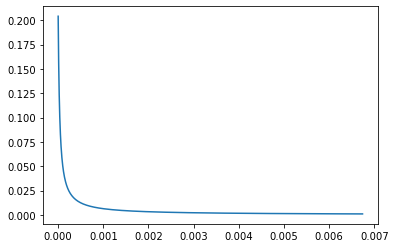

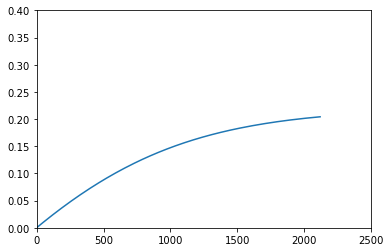

In [11]:
z_loc = 8

distortion_z = np.array([dist[z_loc] for dist in distortions])
r_z = np.array([r[z_loc] for r in rs])
ℓs = np.array(ℓs)
plt.figure()
plt.plot(ℓs, distortion_z)
plt.figure()
plt.plot(r_z, distortion_z)
plt.xlim(0, 2500)
plt.ylim(0, 0.4)

### Simulation

In [12]:
z_loc = 8

ϕ_z = np.array([ϕ[z_loc] for ϕ in ϕs])
r_z = np.array([r[z_loc] for r in rs])
dist_z = np.array([dist[z_loc] for dist in distortions])
sort_indices = np.argsort(r_z)
ϕ_z_sorted = ϕ_z[sort_indices]
r_z_sorted = r_z[sort_indices]
dist_z_sorted = dist_z[sort_indices]

# Calculate dϕ/dr, e_star
r_z, indices = np.unique(r_z_sorted, return_index=True)
ϕ_z = ϕ_z_sorted[indices]
dist_z = dist_z_sorted[indices]
ϕ_der = (ϕ_z[1:]-ϕ_z[:-1])/(r_z[1:]-r_z[:-1])
r_z = (r_z[1:]+r_z[:-1])/2
ϕ_z = (ϕ_z[1:]+ϕ_z[:-1])/2
dist_z = (dist_z[1:]+dist_z[:-1])/2
e_z = δ*η/(τ*z_grid[z_loc]+ϕ_der)

In [13]:
def simulation(e_grid, r_grid, dist_grid, r_start=1500, T=100):
    """
    Simulate emission trajectory baesd on grids of emission and reserve.

    Parameters
    ----------
    e_grid : (N, ) ndarray
        Grid of emission.
    r_grid : (N, ) ndarray
        Grid of reserve.

    Returns
    -------
    Et : (T, ) ndarray
        Emission trajectory.

    """
    Et = np.zeros(T)
    dist_t = np.zeros(T)
    r_remain = r_start
    for i in range(T):
        loc = find_nearest_value(r_grid, r_remain)
        Et[i] = e_grid[loc]
        dist_t[i] = dist_grid[loc]
        r_remain = r_remain - Et[i]
    return Et, dist_t


def find_nearest_value(array, value):
    loc = np.abs(array - value).argmin()
    return loc

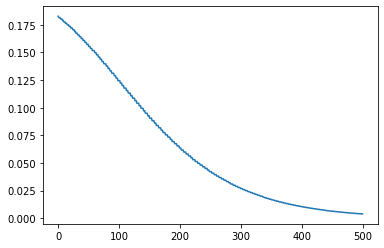

In [14]:
Et, dist_t = simulation(e_z, r_z, dist_z, r_start=1500, T=500)
# plt.plot(Et)
plt.plot(dist_t)

# import matplotlib.pyplot as plt
# plt.plot(Et_7, label=r'10% percentile of $Z_2$')
# plt.plot(Et_10, label=r'50% percentile of $Z_2$')
# plt.plot(Et_13, label=r'90% percentile of $Z_2$')
# plt.legend()
# plt.xlabel('Year')
# plt.ylabel('Emission')
# plt.title('Emission trajectory')
# plt.savefig('plot.pdf')

In [ ]:
plt.plot(Et_7[:200], label=r'10% percentile of $Z_2$')
plt.plot(Et_10[:200], label=r'50% percentile of $Z_2$')
plt.plot(Et_13[:200], label=r'90% percentile of $Z_2$')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Emission')
plt.title(r'Emission trajectory, $\xi=0.00256$')
plt.savefig('plot_200.pdf')

In [ ]:
# Simulation to compute quantile
# dZ = -ρ*(Z-μ_2)*dt + np.sqrt(Z)*σ_2*dW
def simulate(T=1_000_000):
    Ws = np.random.normal(size=T)
    Z = np.zeros(T)
    Z[0] = μ_2
    for i in range(1, T):
        Z[i] = Z[i-1] + (Z[i-1]-μ_2)*(-ρ) + np.sqrt(Z[i-1])*σ_2*Ws[i]
    return Z

In [ ]:
Z = simulate(T=1_000_000)

In [ ]:
# np.quantile(Z, 0.90)

In [ ]:
0.6994771371520058 # 10%, 7
0.9875416359997453 # 50%, 10
1.3172478454208487 # 90%, 13